In [1]:
# All package imports
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import randint
import matplotlib.pyplot as plt
from io import StringIO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import xgboost as xgb

In [2]:
#loading that dataset as a pandas dataframe
data = pd.read_csv('D:\\consumercomplaints.csv')

In [3]:
data.shape

(3101969, 7)

In [4]:
#display first few rows of data
data.head(2).T

,0,1
Unnamed: 0,0,1
Date received,2022-11-11,2022-11-23
Product,Mortgage,"Credit reporting, credit repair services, or o..."
Sub-product,Conventional home mortgage,Credit reporting
Issue,Trouble during payment process,Improper use of your report
Sub-issue,NaN,Reporting company used your report improperly
Consumer complaint narrative,NaN,NaN


In [5]:
#The dataset contains only two vital columns that are important to use in perform the classification of user complaints. This columns are Product and Consumer complaint narrative columns
#Creating a new dataframe that contains only those two features

new_data = data[["Consumer complaint narrative", "Product"]].copy()
new_data.columns = ["consumer_complaints", "product"] #renaming columns

In [6]:
new_data

,consumer_complaints,product
0,NaN,Mortgage
1,NaN,"Credit reporting, credit repair services, or o..."
2,NaN,Mortgage
3,"Hi, I have been banking with Wells Fargo for o...",Checking or savings account
4,NaN,Mortgage
...,...,...
3101964,I have disputed my debts several times with no...,Debt collection
3101965,My father died in XX/XX/XXXX. Left me his only...,Mortgage
3101966,cfbp i would Like to file a complaint on Exper...,Credit reporting
3101967,My husband and I are in the middle of an FHA S...,Credit reporting


In [7]:
#find row with null values

print(new_data.isnull().sum())

consumer_complaints    1987977
product                      0
dtype: int64


In [8]:
#Removing missiong values (NAN)
new_data = new_data[pd.notnull(new_data['consumer_complaints'])]

#size of the dataset
new_data.shape, new_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1113992 entries, 3 to 3101967
Data columns (total 2 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   consumer_complaints  1113992 non-null  object
 1   product              1113992 non-null  object
dtypes: object(2)
memory usage: 25.5+ MB


((1113992, 2), None)

In [9]:
#Lets look into the unique values in our label
pd.DataFrame(new_data['product'].unique(), columns=["Unique Products"])

,Unique Products
0,Checking or savings account
1,Debt collection
2,"Credit reporting, credit repair services, or o..."
3,Mortgage
4,Credit card or prepaid card
5,"Money transfer, virtual currency, or money ser..."
6,Student loan
7,Vehicle loan or lease
8,"Payday loan, title loan, or personal loan"
9,Bank account or service


From the unique products we can see that we have 18 unique products but then it is observer that some are contained in others e.g(credit card, prepaid card, Credit card or prepaid card). Not taking care of this will affect our model performance

In [10]:
print(f"The size of the dataset is {new_data.shape}")

# due to the large amount of data and its implication on compute power, we will be sampling the data to only 500000 rows
sample_data = new_data.sample(10000, random_state=5).copy()

The size of the dataset is (1113992, 2)


In [11]:
sample_data.shape

(10000, 2)

In [12]:
sample_data.replace({
    'product':
             {'Credit reporting, credit repair services, or other personal consumer reports':
              'Credit reporting, repair, or other',
              'Credit reporting': 'Credit reporting, repair, or other',
             'Credit card': 'Credit card or prepaid card',
             'Prepaid card': 'Credit card or prepaid card',
             'Payday loan': 'Payday loan, title loan, or personal loan',
             'Money transfer': 'Money transfer, virtual currency, or money service',
             'Virtual currency': 'Money transfer, virtual currency, or money service'}
    },
            inplace= True)


In [13]:
pd.DataFrame(sample_data['product'].unique(), columns=["Unique Products"])

,Unique Products
0,"Credit reporting, repair, or other"
1,Mortgage
2,Debt collection
3,Credit card or prepaid card
4,Checking or savings account
5,"Payday loan, title loan, or personal loan"
6,"Money transfer, virtual currency, or money ser..."
7,Consumer Loan
8,Student loan
9,Bank account or service


In [14]:
sample_data["category_id"] = sample_data['product'].factorize()[0]

In [15]:
sample_data.head()

,consumer_complaints,product,category_id
540928,XXXX XXXX is trying to collect on behalf of XX...,"Credit reporting, repair, or other",0
2581386,Letter of Deletion XXXX XXXX XXXX XXXX XXXX X...,"Credit reporting, repair, or other",0
2025396,My direct student loan accounts were in a defa...,"Credit reporting, repair, or other",0
48706,"I'm XXXX XXXX, and I need your help getting in...","Credit reporting, repair, or other",0
1431994,"Bank of America ( "" BOA '' ) serviced our mort...","Credit reporting, repair, or other",0


In [16]:
##creating identifiers for our product matching its category id
category_id_data = sample_data[['product','category_id']].drop_duplicates()

category_id_data

,product,category_id
540928,"Credit reporting, repair, or other",0
1613018,Mortgage,1
2694984,Debt collection,2
2494564,Credit card or prepaid card,3
1371890,Checking or savings account,4
932893,"Payday loan, title loan, or personal loan",5
788416,"Money transfer, virtual currency, or money ser...",6
2167803,Consumer Loan,7
204012,Student loan,8
1703680,Bank account or service,9


We have excellently encoded the product to numerical values which will be used for prediction... Lets store this as key value pairs for later usage

In [17]:
category_to_id = dict(category_id_data.values)
category_to_id

{'Credit reporting, repair, or other': 0,
 'Mortgage': 1,
 'Debt collection': 2,
 'Credit card or prepaid card': 3,
 'Checking or savings account': 4,
 'Payday loan, title loan, or personal loan': 5,
 'Money transfer, virtual currency, or money service': 6,
 'Consumer Loan': 7,
 'Student loan': 8,
 'Bank account or service': 9,
 'Vehicle loan or lease': 10,
 'Money transfers': 11,
 'Other financial service': 12}

In [18]:
id_to_category = dict(category_id_data[['category_id','product']].values)
id_to_category

{0: 'Credit reporting, repair, or other',
 1: 'Mortgage',
 2: 'Debt collection',
 3: 'Credit card or prepaid card',
 4: 'Checking or savings account',
 5: 'Payday loan, title loan, or personal loan',
 6: 'Money transfer, virtual currency, or money service',
 7: 'Consumer Loan',
 8: 'Student loan',
 9: 'Bank account or service',
 10: 'Vehicle loan or lease',
 11: 'Money transfers',
 12: 'Other financial service'}

Lets sort the product based on the customer complaints received


In [19]:
sample_data.groupby('product')['consumer_complaints'].count().sort_values()

product
Other financial service                                  1
Money transfers                                         14
Consumer Loan                                           83
Payday loan, title loan, or personal loan              121
Bank account or service                                125
Vehicle loan or lease                                  180
Money transfer, virtual currency, or money service     232
Student loan                                           267
Checking or savings account                            497
Mortgage                                               900
Credit card or prepaid card                            918
Debt collection                                       1770
Credit reporting, repair, or other                    4892
Name: consumer_complaints, dtype: int64

<Axes: title={'center': 'No Of Complaints In Each Product Category\n'}, ylabel='product'>

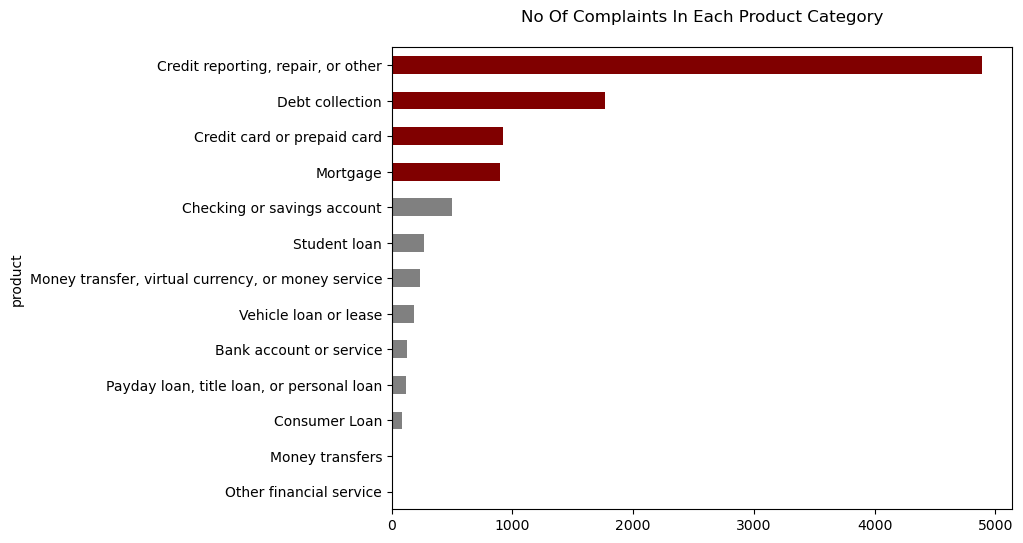

In [20]:
fig = plt.figure(figsize=(8,6))


# colors = ['grey','grey','grey','grey','grey','grey','grey','grey','grey',
#     'grey','maroon','maroon','maroon']

colors = ["maroon" if color >= 9 else "grey" for color in range(0,13) ]


sample_data.groupby('product')['consumer_complaints'].count().sort_values().plot.barh(
    ylim=0, color=colors, title= 'No Of Complaints In Each Product Category\n')

# **Preprocessing Text with TF-IDF**
TF-IDF stands for "Term Frequency-Inverse Document Frequency." It is a numerical statistic used in information retrieval and text mining to evaluate the importance of a word in a document relative to a collection of documents (corpus). TF-IDF is based on the idea that the importance of a word increases proportionally to the number of times it appears in the document (term frequency), but is offset by the frequency of the word in the corpus (inverse document frequency), which helps to account for the fact that some words are generally more common across all documents.

Here's a brief breakdown of TF-IDF components:

1. **Term Frequency (TF)**: Measures the frequency of a term (word) within a document. It is calculated as the number of times a term appears in a document divided by the total number of terms in the document.

   TF(t,d)=
Total number of terms in document d /
Number of times term t appears in document d
​

2. **Inverse Document Frequency (IDF)**: Measures the significance of a term across a collection of documents (corpus). It is calculated as the logarithm of the total number of documents divided by the number of documents containing the term, with the result inverted.

   IDF(t,D)=log(
Number of documents containing term t/
Total number of documents in corpus D
​
 )

3. **TF-IDF**: Combines both TF and IDF to measure the importance of a term in a specific document relative to the entire corpus. It is calculated as the product of TF and IDF.

   TF-IDF(t,d,D)=TF(t,d)×IDF(t,D)

The TF-IDF model assigns higher weights to terms that are frequent within a document (TF) but rare across the corpus (IDF), thereby emphasizing terms that are both relevant and discriminative for characterizing the content of a document. TF-IDF is commonly used in various natural language processing tasks, such as text classification, document similarity, and information retrieval.

TfidfVectorizer class can be initialized with the following parameters:

**min_df**: remove the words from the vocabulary which have occurred in less than ‘min_df’ number of files.

**max_df**: remove the words from the vocabulary which have occurred in more than _‘maxdf’ * total number of files in corpus.

**sublinear_tf**: set to True to scale the term frequency in logarithmic scale.

**stop_words**: remove the predefined stop words in 'english'.

**use_idf**: weight factor must use inverse document frequency.

**ngram_range**: (1, 2) to indicate that unigrams and bigrams will be considered.

In [21]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Assuming X is your list of text documents
# Create TF-IDF vectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,  ngram_range=(1,2), stop_words='english')

# Create StandardScaler
# scaler = StandardScaler(with_mean=False)

# Combine TF-IDF vectorization and StandardScaler into a pipeline
pipeline = Pipeline([
    ('tfidf', tfidf)
    # ('scaler', scaler)
])

# Fit and transform the data using the pipeline
features = pipeline.fit_transform(sample_data['consumer_complaints']).toarray()



In [22]:
# features = tfidf.fit_transform(sample_data['consumer_complaints'][:]).toarray()

In [23]:
#The cell above transformed the input data into a vector transform
print("Each of the %d complaints is represented by %d features (TF-IDF score of unigrams and bigrams)" %(features.shape))

Each of the 10000 complaints is represented by 26961 features (TF-IDF score of unigrams and bigrams)


In [24]:
features[:5]

array([[0.04071582, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.04594001, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [25]:
labels = sample_data.category_id

## Multi-Classification models
The classification models evaluated are:- 

Random For
- st
Linear Support Vector Mac
- ine
Multinomial Naive B- ayes
Logistic Regression.

In [26]:
#splitting into feature and target
x = new_data["consumer_complaints"]
y = new_data["product"]

In [27]:
#splitting into train and test sets
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.25, random_state=0)

In [28]:
#models to be trained
models = [
    # RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]


In [29]:
rfc_model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0)
rfc_model.fit(x_train, y_train)
accuracy = rfc_model.score(x_test, y_test)
print("Accuracy:", accuracy)

Accuracy: 0.4956


In [30]:
accuracy = rfc_model.score(x_test, y_test)
print("Accuracy:", accuracy)

Accuracy: 0.4956


In [31]:
#performing crossvalidation, mostly aimed at improving models accuracy 
cv = 3
entries = []

for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring="accuracy", cv=cv)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
    
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

C:\Users\micah\miniconda3\envs\mlenv\Lib\site-packages\sklearn\model_selection\_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
C:\Users\micah\miniconda3\envs\mlenv\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\micah\miniconda3\envs\mlenv\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\micah\miniconda3\envs\mlenv\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\micah\miniconda3\envs\mlenv\Lib\site-package

In [32]:
cv_df

,model_name,fold_idx,accuracy
0,LinearSVC,0,0.804739
1,LinearSVC,1,0.804080
2,LinearSVC,2,0.813681
3,MultinomialNB,0,0.621176
4,MultinomialNB,1,0.625263
5,MultinomialNB,2,0.627363
6,LogisticRegression,0,0.784943
7,LogisticRegression,1,0.792379
8,LogisticRegression,2,0.789979


In [33]:
mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
std_accuracy = cv_df.groupby('model_name').accuracy.std()

comparison = pd.concat([mean_accuracy, std_accuracy], axis= 1, 
          ignore_index=True)
comparison.columns = ['Mean Accuracy', 'Standard deviation']

In [34]:
comparison

,Mean Accuracy,Standard deviation
model_name,,
LinearSVC,0.8075,0.005363
LogisticRegression,0.7891,0.003795
MultinomialNB,0.6246,0.003146


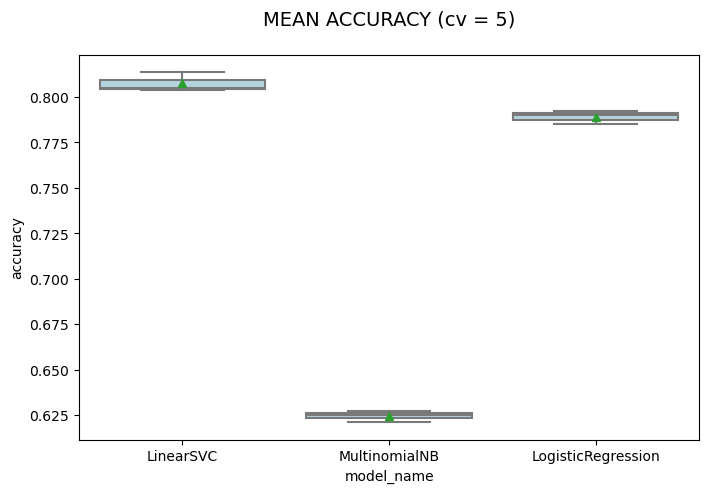

In [35]:
plt.figure(figsize=(8,5))
sns.boxplot(x='model_name', y='accuracy', 
            data=cv_df, 
            color='lightblue', 
            showmeans=True)
plt.title("MEAN ACCURACY (cv = 5)\n", size=14);

From the list of models we have trained on it can be seen that the LinearSVC model performs much better than the others

## HyperParameter Tunning of LinearSVC model



In [36]:
x_train, x_test, y_train, y_test = train_test_split(features,
                                                    labels, 
                                                    test_size=0.25, 
                                                    random_state=1)
lsvc = LinearSVC(loss='hinge',
                  penalty='l2', max_iter = 100)

In [37]:
lsvc.fit(x_train, y_train)
y_pred = lsvc.predict(x_test)

C:\Users\micah\miniconda3\envs\mlenv\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\micah\miniconda3\envs\mlenv\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [39]:
lsvc.score(x_test, y_test)

0.8104

In [38]:
# classification report ;  evaluation metrics for classification based models
print(metrics.classification_report(y_test, y_pred, 
                                    target_names= sample_data['product'].unique()))

                                                    precision    recall  f1-score   support

                Credit reporting, repair, or other       0.86      0.93      0.89      1205
                                          Mortgage       0.82      0.90      0.86       212
                                   Debt collection       0.77      0.77      0.77       472
                       Credit card or prepaid card       0.71      0.69      0.70       228
                       Checking or savings account       0.68      0.73      0.70       128
         Payday loan, title loan, or personal loan       1.00      0.10      0.18        30
Money transfer, virtual currency, or money service       0.64      0.71      0.67        48
                                     Consumer Loan       0.00      0.00      0.00        17
                                      Student loan       0.86      0.75      0.80        73
                           Bank account or service       0.50      0.06      0.

C:\Users\micah\miniconda3\envs\mlenv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\micah\miniconda3\envs\mlenv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\micah\miniconda3\envs\mlenv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [45]:
## KNearestNeigbours
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=7)
neigh.fit(x_train, y_train)
accuracy = neigh.score(x_test, y_test)
print("Accuracy:", accuracy)

Accuracy: 0.7252


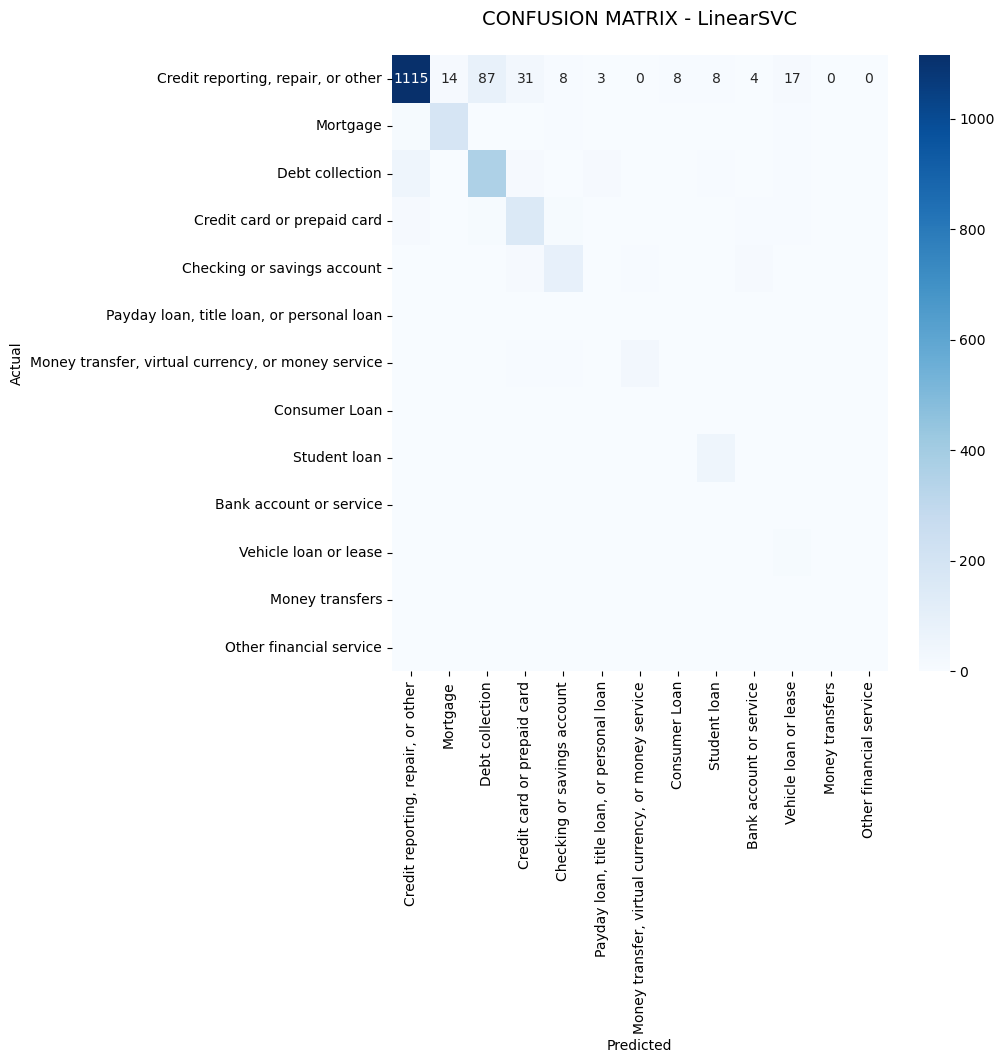

In [65]:
conf_mat = confusion_matrix(y_pred, y_test)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=category_id_data['product'].values, 
            yticklabels=category_id_data['product'].values);
plt.ylabel('Actual');
plt.xlabel('Predicted');
plt.title("CONFUSION MATRIX - LinearSVC\n", size=14);

In [70]:
x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                    test_size=0.25,
                                                    random_state = 0)

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2), 
                        stop_words='english')

fitted_vectorizer = tfidf.fit(x_train)
tfidf_vectorizer_vectors = fitted_vectorizer.transform(x_train)

model = LinearSVC().fit(tfidf_vectorizer_vectors, y_train)

C:\Users\micah\miniconda3\envs\mlenv\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


In [71]:
new_complaint = """I have been enrolled back at XXXX XXXX University in the XX/XX/XXXX. Recently, i have been harassed by \
Navient for the last month. I have faxed in paperwork providing them with everything they needed. And yet I am still getting \
phone calls for payments. Furthermore, Navient is now reporting to the credit bureaus that I am late. At this point, \
Navient needs to get their act together to avoid me taking further action. I have been enrolled the entire time and my \
deferment should be valid with my planned graduation date being the XX/XX/XXXX."""
print(model.predict(fitted_vectorizer.transform([new_complaint])))

['Student loan']


In [73]:
import joblib

#dump our model into a pkl file

svcModel = joblib.dump(model, 'linear_svc_model.pkl')


In [79]:
# Load the saved model
model = joblib.load('linear_svc_model.pkl')

# Sample data for testing
sample_data =  ["Hi, I have been banking with Wells Fargo for over a decade. Within the past 2 years, my grandfather started me sending me money in fairly frequent increments. Rather than using a new age, free transfer system, he uses old fashion wire transfers because he is over XXXX XXXX XXXX and this is what he prefers. \n\nEach time he sends me money, Wells Fargo takes a {$16.00} service fee. Over the past 2 or so years, this has added up to {$490.00} dollars in fees, to run a process with little to no costs to the bank. I asked to have some or all of the funds refunded because these fees are incredibly excessive, but they were unwilling to do so ( they actually were willing to refund some of the money over the phone but then none of the money over email/messages, which shows poor process control and an arbitrary system of refunds ) This feels excessive. They are basically taking money from my grandfather since he is too old to learn how to use new systems. Feels like this matches a pattern that Wells Fargo has exhibited the past few years of taking money from clients in made up fees."]

# Perform TF-IDF transformation on sample data
tfidf_vectorizer_vectors_test = fitted_vectorizer.transform(sample_data)

# Make predictions using the loaded model
predictions = model.predict(tfidf_vectorizer_vectors_test)

# Display predictions
print("Predictions:", predictions)


Predictions: ['Checking or savings account']


In [77]:
x[3]


'Hi, I have been banking with Wells Fargo for over a decade. Within the past 2 years, my grandfather started me sending me money in fairly frequent increments. Rather than using a new age, free transfer system, he uses old fashion wire transfers because he is over XXXX XXXX XXXX and this is what he prefers. \n\nEach time he sends me money, Wells Fargo takes a {$16.00} service fee. Over the past 2 or so years, this has added up to {$490.00} dollars in fees, to run a process with little to no costs to the bank. I asked to have some or all of the funds refunded because these fees are incredibly excessive, but they were unwilling to do so ( they actually were willing to refund some of the money over the phone but then none of the money over email/messages, which shows poor process control and an arbitrary system of refunds ) This feels excessive. They are basically taking money from my grandfather since he is too old to learn how to use new systems. Feels like this matches a pattern that W

In [80]:
y[3]

'Checking or savings account'